In [92]:
import os
import numpy as np
import pandas as pd
import json
import copy

In [93]:
data_path = '/opt/ml/dataset'
train_json = "/opt/ml/dataset/train.json"
test_json = "/opt/ml/dataset/test.json"
best_csv = '/opt/ml/baseline/mmdetection/work_dirs/dh_uniswinL.csv'

In [94]:
with open(test_json, 'r') as f:
    test_json = json.load(f)

In [95]:
#test.json의 images 항목을 train.json images 항목에 덧붙이기 위한 copy
img_dict_list = copy.deepcopy(test_json['images']) 

# csv 파일 읽어오기
with open(best_csv) as f:
    pseudo = pd.read_csv(f)
    
# train.json 읽어오기 
with open(train_json, "r") as f:
    train_data = json.load(f)


print("test 이미지 수 : ", len(pseudo))    
print("train 이미지 수 : ", len(train_data['images']))

test 이미지 수 :  4871
train 이미지 수 :  4883


In [96]:
# 슈도 라벨링할 이미지 개수 지정
num_images = 5
annotation_id = 23144
cnt,total = 0,0
annotations = []
for i in range(len(pseudo)):
    img_id = pseudo['image_id'][i] #0001
    img_id = i+4883 #len(train_data['images'])+i  # train.json이 4882번까지 존재하므로 뒤에 붙여줘야하므로 +4883
    img_dict_list[i]['id'] = img_id

    PredictionString = pseudo['PredictionString'][i].strip()
    split_lst = PredictionString.split(" ")

    top_k_conf_list = sorted(split_lst[1::6], reverse=True)[:num_images]
    confidence_thr = float(top_k_conf_list[-1]) #임계값 설정
    bbox_dicts = []
    #print(confidence_thr)
    for j in range(0, len(split_lst), 6):
        if float(split_lst[j + 1]) < confidence_thr or float(split_lst[j + 1]) < 0.6: #임계값보다 작으면 무시
            continue
        
        bbox_dict = {}
        bbox_dict['image_id'] = img_id
        bbox_dict['category_id'] = int(split_lst[j])
        x,y,w,h = float(split_lst[2+j]), float(split_lst[3+j]) , float(split_lst[4+j])-float(split_lst[2+j]), float(split_lst[5+j])-float(split_lst[3+j])
        bbox_dict['bbox'] = [x,y,w,h]
        bbox_dict['area'] = w*h
        bbox_dict['iscrowd'] = 0
        bbox_dict['id'] = annotation_id
        annotation_id += 1
        bbox_dicts.append(bbox_dict)
    if len(bbox_dicts) != num_images:
        print(i, confidence_thr,"- iamge bbox total:",len(split_lst)//6 ,"   pseudo total:",len(bbox_dicts),)
    if len(split_lst)//6<=5:
        cnt += 1
    #     print(confidence_thr)
    total += 1
    annotations.extend(bbox_dicts)

    if i % 1000 == 0:
        print(f"Processed {i} / {len(pseudo)}")
        
train_data['images'].extend(img_dict_list)
train_data['annotations'].extend(annotations)

with open( os.path.join(data_path, 'pseudo_label_5_0.6.json'), mode='w') as f:
    f.write(json.dumps(train_data, indent=2))
print("-----FINISH-----")
print(total, cnt)

Processed 0 / 4871
1 0.41849402 - iamge bbox total: 26    pseudo total: 2
3 0.26526004 - iamge bbox total: 32    pseudo total: 1
4 0.17688349 - iamge bbox total: 31    pseudo total: 2
5 0.05990892 - iamge bbox total: 2    pseudo total: 1
6 0.56843424 - iamge bbox total: 100    pseudo total: 4
7 0.40824962 - iamge bbox total: 100    pseudo total: 3
9 0.06101972 - iamge bbox total: 3    pseudo total: 1
10 0.3599488 - iamge bbox total: 100    pseudo total: 3
12 0.08267962 - iamge bbox total: 9    pseudo total: 1
13 0.45806894 - iamge bbox total: 100    pseudo total: 2
14 0.32080358 - iamge bbox total: 69    pseudo total: 2
15 0.3643147 - iamge bbox total: 100    pseudo total: 1
16 0.07846249 - iamge bbox total: 13    pseudo total: 2
17 0.09091562 - iamge bbox total: 8    pseudo total: 0
18 0.33858743 - iamge bbox total: 100    pseudo total: 3
20 0.2803349 - iamge bbox total: 3    pseudo total: 1
21 0.100811675 - iamge bbox total: 10    pseudo total: 0
22 0.2020129 - iamge bbox total: 15  

## 확인하기

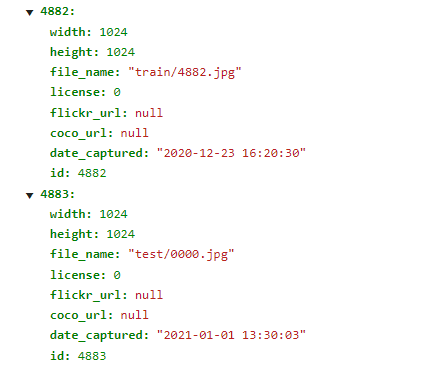

train 이미지가 끝나고 test 이미지의 정보가 생성된 것 확인 (copy ok !)

## annotation 확인하기

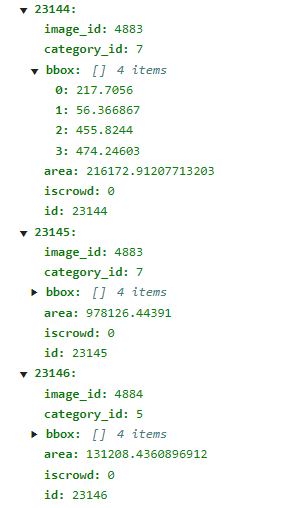

CSV 파일<br>
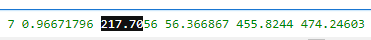

num_images를 2로 설정해서 컨피던스 기준으로 2개의 bbox가 생성된 것을 확인할 수 있음
좌표값도 csv파일과 비교했을 때, 잘 들어간 것 확인

In [36]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
with open("/opt/ml/dataset/pseudo_labeling5.json",'r') as f:
 json_data = json.load(f)
df = pd.DataFrame({'image_id':[], "category_id":[],'Xmin':[], 'Ymin':[], 'width':[], 'height':[],
                   'ratio':[], 'area':[]})

for i,info in enumerate(json_data['annotations']):
    df.loc[i] = [
        int(info['image_id']), 
        int(info['category_id']), 
        info['bbox'][0], 
        info['bbox'][1],
        info['bbox'][2],
        info['bbox'][3],
        round(info['bbox'][2]/info['bbox'][3],1),
        info['area'],
    ]
    
print(df.head())

   image_id  category_id   Xmin   Ymin  width  height  ratio       area
0       0.0          0.0  197.6  193.7  547.8   469.7    1.2  257301.66
1       1.0          3.0    0.0  407.4   57.6   180.6    0.3   10402.56
2       1.0          7.0    0.0  455.6  144.6   181.6    0.8   26259.36
3       1.0          4.0  722.3  313.4  274.3   251.9    1.1   69096.17
4       1.0          5.0  353.2  671.0  233.7   103.4    2.3   24164.58


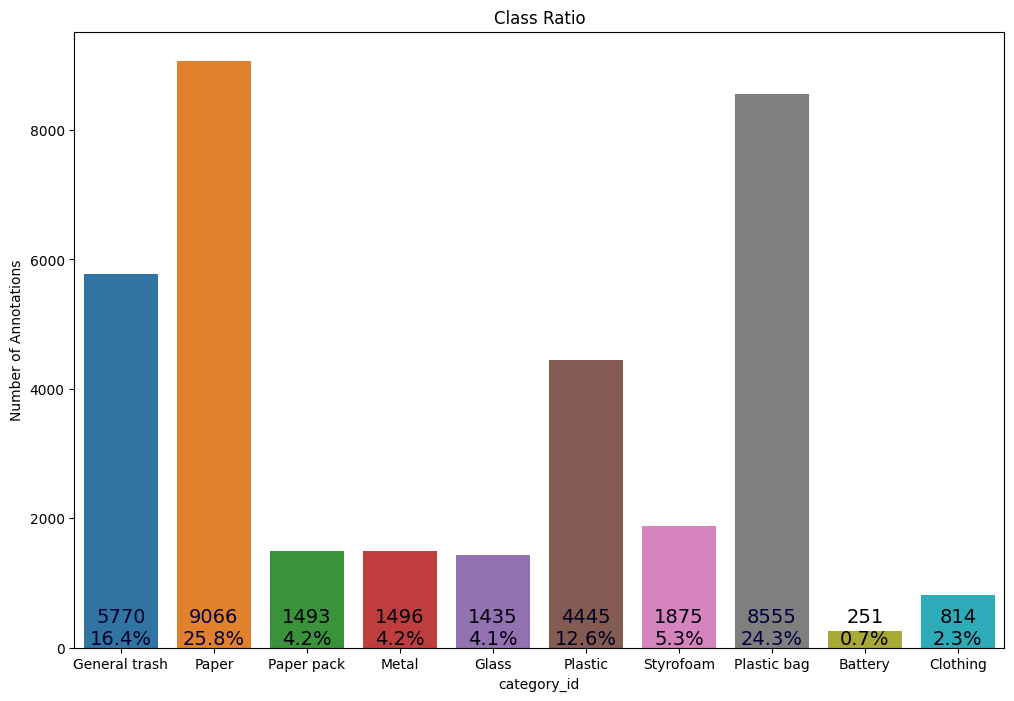

In [37]:
# category id 분포
plt.figure(figsize=(12, 8))
ax = sns.countplot(x='category_id', data=df)
plt.title("Class Ratio")
plt.ylabel("Number of Annotations")
plt.xticks(range(10), map(lambda x: x['name'], json_data['categories']))
count = df['category_id'].value_counts()
count = dict(sorted(count.items()))
for i, (cat_id, cat_count) in enumerate(count.items()):
    ratio = cat_count / sum(count.values()) * 100
    ax.text(i, 50, f'{cat_count}\n{ratio:.1f}%', ha='center', size=14, color=(0, 0, ratio / 100))
plt.show()


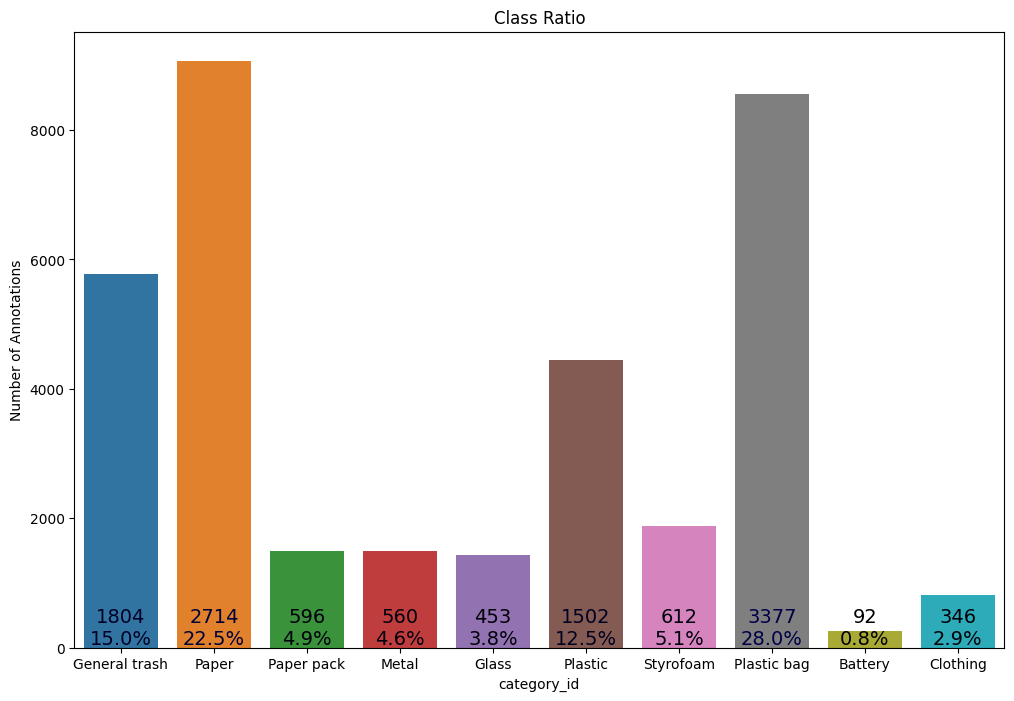

In [38]:
# 클래스 분포 개수를 anno_id가 23144 이상인 것만 선택하여 표시
count = df[df['image_id'] >= 4883]['category_id'].value_counts()
count = dict(sorted(count.items()))

# 나머지 코드는 동일
plt.figure(figsize=(12, 8))
ax = sns.countplot(x='category_id', data=df)
plt.title("Class Ratio")
plt.ylabel("Number of Annotations")
plt.xticks(range(len(count)), map(lambda x: x['name'], json_data['categories']))
for i, (cat_id, cat_count) in enumerate(count.items()):
    ratio = cat_count / sum(count.values()) * 100
    ax.text(i, 50, f'{cat_count}\n{ratio:.1f}%', ha='center', size=14, color=(0, 0, ratio / 100))
plt.show()
